In [2]:
import os, cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album

import segmentation_models_pytorch as smp

from pathlib import Path
import pydicom as dicom
import nibabel as nib
from sklearn.model_selection import train_test_split
import wandb

In [4]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = './__notebook_source__.ipynb'

# REPLACE WITH UR API KEY
os.environ['WANDB_API_KEY'] = '7c144d21cca6113f3894cef8de4cca55327263eb'

wandb.login()

wandb.init(
    project = 'dlv3plus-segm',
    notes = """
        Model: DeepLabV3+
        Stage: 1
        Epochs: 10
        Optimizer: AdamW/1e-4/5e-5
        Scheduler: MultiStep/[1,10]/0.1
        Backbone: EffNetV2-M (imagenet)
        Classes: 1 + 7 + 1
        Strategy: Train all with classes + 10% empty
        Augmentation: Rotations/0.25
    """
)

# Initialize config for this experiment
wandb.config = {
    'batch_size' : 8,
    'val_batch_size' : 8,
    'num_workers' : os.cpu_count(),
    'train_size' : 0.935,
    'val_size' : 0.033,
    'test_size' : 0.032,
    'device' : 'cuda:0' if torch.cuda.is_available() else 'cpu',
    'n_epochs' : 10
}

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./__notebook_source__.ipynb.
wandb: Currently logged in as: hitogamiag. Use `wandb login --relogin` to force relogin


# Data

In [6]:
meta_segm = pd.read_csv('/kaggle/input/rsna-2022-spine-fracture-detection-metadata/meta_segmentation_clean.csv')
meta_segm.head()

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10633,4,512,512,1.0,-68.0,98.0,312.599976,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.10633,5,512,512,1.0,-68.0,98.0,312.099976,0,0,0,0,0,0,0


In [7]:
#meta_segm = meta_segm[(meta_segm.iloc[:, 8:] != 0).any(1)]

In [8]:
# PATH VARS

dicom_path = Path('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/train_images/')
segm_path = Path('/kaggle/input/rsna-2022-cervical-spine-fracture-detection/segmentations/')
checkpoint_path = Path('./checkpoints/')

In [9]:
# True means need to flip Z axis, False otherwise
orientation_check = {}
for uid in meta_segm.StudyInstanceUID.unique():
    dcm1 = dicom.dcmread(dicom_path / uid / (str(10) + '.dcm'))
    dcm2 = dicom.dcmread(dicom_path / uid / (str(20) + '.dcm'))
    if (dcm1.ImagePositionPatient[2] - dcm2.ImagePositionPatient[2]) > 0:
        orientation_check[uid] = True
    else:
        orientation_check[uid] = False

In [10]:
masks = {}
for uid in meta_segm.StudyInstanceUID.unique():
    mask = nib.load(segm_path / (uid + '.nii'))
    mask = np.asarray(mask.get_data())
    if orientation_check[uid]:
        mask = mask[:, :, ::-1]
    mask = np.rot90(mask, k=1, axes=(0, 1))
    masks[uid] = mask

In [11]:
"""
Split patients into train/val/test
"""

train_UIDs, test_val_UIDs = train_test_split(meta_segm.StudyInstanceUID.unique(),
                                                   test_size=wandb.config['val_size'] + wandb.config['test_size'],
                                                   random_state=42)
val_UIDs, test_UIDs = train_test_split(test_val_UIDs, test_size= wandb.config['test_size'] / (wandb.config['test_size'] + wandb.config['val_size']),
                                       random_state=42)

print(f'Number of UIDs in train: {len(train_UIDs)}')
print(f'Number of UIDs in val: {len(val_UIDs)}')
print(f'Number of UIDs in test: {len(test_UIDs)}')

train_UIDs, val_UIDs, test_UIDs = train_UIDs.tolist(), val_UIDs.tolist(), test_UIDs.tolist()


Number of UIDs in train: 81
Number of UIDs in val: 3
Number of UIDs in test: 3


In [12]:
"""
Write train/val/test spilts
"""

def write_UIDs_in_txt(UIDs, txt_name):
    with open(txt_name, 'w') as file:
        file.write('\n'.join(UIDs))
        
def read_UIDs_from_txt(txt_name):
    with open(txt_name, 'r') as file:
        return file.read().split('\n')

# When train on kaggle, must be True
write_files = True
if write_files:   # switch to True to rewrite train/val/test split
    write_UIDs_in_txt(train_UIDs, 'train_UIDs.txt')
    write_UIDs_in_txt(val_UIDs, 'val_UIDs.txt')
    write_UIDs_in_txt(test_UIDs, 'test_UIDs.txt')
    write_files = False

train_UIDs = read_UIDs_from_txt('train_UIDs.txt')
val_UIDs = read_UIDs_from_txt('val_UIDs.txt')
test_UIDs = read_UIDs_from_txt('test_UIDs.txt')

In [13]:
train_df = meta_segm[meta_segm.StudyInstanceUID.isin(train_UIDs)]
val_df = meta_segm[meta_segm.StudyInstanceUID.isin(val_UIDs)]
test_df = meta_segm[meta_segm.StudyInstanceUID.isin(test_UIDs)]

print(f'Shape of train dataframe: {train_df.shape}')
print(f'Shape of val dataframe: {val_df.shape}')
print(f'Shape of test dataframe: {test_df.shape}')

Shape of train dataframe: (27524, 15)
Shape of val dataframe: (944, 15)
Shape of test dataframe: (1364, 15)


In [14]:
minmax_traindf = train_df[(train_df.iloc[:, 8:] != 0).any(1)].groupby('StudyInstanceUID').agg({'Slice':['min', 'max']})

mask_train_df = train_df[['StudyInstanceUID', 'Slice']]
mask_train_df['pos_label'] = mask_train_df.apply(lambda x: 1 if x.Slice < minmax_traindf.loc[x.StudyInstanceUID].min() \
                                                else 3 if x.Slice > minmax_traindf.loc[x.StudyInstanceUID].max()\
                                                else 2, axis=1)

In [15]:
def reshuffle_traindf(train_df, masked_df):
    records_to_get = pd.concat([
        mask_train_df[mask_train_df.pos_label == 2],
        mask_train_df[mask_train_df.pos_label == 1].sample(frac=0.1, random_state=42),
        mask_train_df[mask_train_df.pos_label == 3].sample(frac=0.1, random_state=42)
    ])
    
    return pd.merge(train_df, records_to_get[["StudyInstanceUID", "Slice"]], on=["StudyInstanceUID", "Slice"], how="inner")

In [16]:
class BuildingDataset(Dataset):
    def __init__(self, dataframe, dicom_path, masks, augmentation = None, preprocessing=None):
        super(BuildingDataset, self).__init__()
        self.class_values = [0, 1, 2, 3, 4, 5, 6, 7, 8]#, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
        self.dataframe = dataframe
        self.dicom_path = dicom_path
        self.masks = masks
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.dataframe)
    
    def load_dicom(self, path):
        # Source: https://www.kaggle.com/code/vslaykovsky/pytorch-effnetv2-vertebrae-detection-acc-0-95
        img=dicom.dcmread(path)
        img.PhotometricInterpretation = 'YBR_FULL'
        data = img.pixel_array
        data = data - np.min(data)
        if np.max(data) != 0:
            data = data / np.max(data)
        data=(data * 255).astype(np.uint8)
        return cv.cvtColor(data, cv.COLOR_GRAY2RGB), img
    
    def encode_mask(self, mask):
        semantic_map = []
        for class_value in self.class_values:
            semantic_map.append(np.equal(mask, class_value).astype(np.uint8))
        return np.stack(semantic_map, axis=-1)
    
    def load_mask(self, uid, slice_number):
        try:
            mask = self.masks[uid][:, :, slice_number]
        except:
            mask = np.zeros((512, 512))
        mask[mask > 7] = 8
        encoded_mask = self.encode_mask(mask)
        return encoded_mask
    
    def __getitem__(self, index):
        record = self.dataframe.iloc[index, :].to_numpy()
        
        img, _ = self.load_dicom(self.dicom_path / record[0] / (str(record[1]) + '.dcm'))
        mask = self.load_mask(record[0], record[1] - 1)
        
        if self.augmentation:
            sample = self.augmentation(image = img, mask = mask)
            img, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            sample = self.preprocessing(image = img, mask = mask)
            img, mask = sample['image'], sample['mask']
        
        return img, mask

In [17]:
def get_training_augmentation():
    train_transform = [
        album.OneOf(
            [
                album.HorizontalFlip(p=1)
            ],
            p=0.25,
        ),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

# Model initialization

In [18]:
ENCODER = 'tu-tf_efficientnetv2_m'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'others']
ACTIVATION = 'softmax2d'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m-cc09e0cd.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_m-cc09e0cd.pth


In [19]:
# model.to('cuda')
# weights = torch.load('/kaggle/input/best-segm-model/best_model.pth')
model = nn.DataParallel(model)
# model.load_state_dict(weights.state_dict())

In [20]:
train_dataset = BuildingDataset(reshuffle_traindf(train_df, mask_train_df), dicom_path, masks, preprocessing=get_preprocessing(preprocessing_fn))
val_dataset = BuildingDataset(val_df, dicom_path, masks, preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers = 5, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers = 2, drop_last=True)

# Training

In [21]:
from segmentation_models_pytorch import utils as smp_utils

In [22]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 12

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp_utils.losses.DiceLoss()

# define metrics
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.AdamW([
    dict(params=model.parameters(), lr=1, weight_decay = 5e-5),
])

# define learning rate scheduler (not used in this NB)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer, T_0=1, T_mult=2, eta_min=5e-5,
# )

def warmup_lambda(current_step):
    if current_step < 0.5:
        return current_step / 1000
    elif current_step < 1:
        return 0.0005
    elif current_step < 6:
        return 0.0001
    else:
        return 0.00005
    
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_lambda)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [23]:
def _format_logs(self, logs):
    to_wandb = logs.copy()
    to_wandb = {f"{self.stage_name}_{key}" : value for key, value in to_wandb.items()}
    if self.stage_name == 'train':
        to_wandb['lr'] = self.optimizer.param_groups[0]['lr']
    wandb.log(to_wandb)
    
    str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
    s = ", ".join(str_logs)
    return s

smp_utils.train.Epoch._format_logs = _format_logs

class TrainEpoch(smp_utils.train.Epoch):
    def __init__(self, model, loss, metrics, optimizer, loader_size, scheduler, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loader_size = loader_size
        self.batch_counter = 1

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step(
            (self.batch_counter // self.loader_size) + ((self.batch_counter % self.loader_size) / self.loader_size)
        )
        
        self.batch_counter += 1
        return loss, prediction
    
smp_utils.train.TrainEpoch = TrainEpoch

In [24]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    loader_size = len(train_loader),
    scheduler = lr_scheduler,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [25]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):
        wandb.log({
            'epoch' : i+1
        })
        # Restart train loader
        train_dataset = BuildingDataset(reshuffle_traindf(train_df, mask_train_df), dicom_path, masks, preprocessing=get_preprocessing(preprocessing_fn))
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers = 5, drop_last=True)
        
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 118/118 [01:03<00:00,  1.86it/s, dice_loss - 0.01127, iou_score - 0.9788]
Model saved!

Epoch: 1
valid: 100%|██████████| 118/118 [01:05<00:00,  1.82it/s, dice_loss - 0.009655, iou_score - 0.9816]
Model saved!

Epoch: 2
valid: 100%|██████████| 118/118 [01:04<00:00,  1.82it/s, dice_loss - 0.006416, iou_score - 0.9877]
Model saved!

Epoch: 3
valid: 100%|██████████| 118/118 [01:05<00:00,  1.80it/s, dice_loss - 0.003474, iou_score - 0.9933]
Model saved!

Epoch: 4
valid: 100%|██████████| 118/118 [01:05<00:00,  1.79it/s, dice_loss - 0.003455, iou_score - 0.9933]

Epoch: 5
valid: 100%|██████████| 118/118 [01:07<00:00,  1.75it/s, dice_loss - 0.00324, iou_score - 0.9937]
Model saved!

Epoch: 6
valid: 100%|██████████| 118/118 [01:04<00:00,  1.82it/s, dice_loss - 0.002913, iou_score - 0.9943]
Model saved!

Epoch: 7
valid: 100%|██████████| 118/118 [01:06<00:00,  1.77it/s, dice_loss - 0.002878, iou_score - 0.9944]
Model saved!

Epoch: 8
valid: 100%|██████████| 118/1

In [26]:
(train_epoch.batch_counter // train_epoch.loader_size) + ((train_epoch.batch_counter % train_epoch.loader_size) / train_epoch.loader_size) / 1000

12.000000441696113

In [27]:
model_name = 'dlv3plus'
save_path = './best_model.pth'
artifact = wandb.Artifact(model_name, type='checkpoint')
artifact.add_file(save_path)
wandb.log_artifact(artifact)
print(f'Logged {model_name}')

Logged dlv3plus


In [28]:
batch = next(iter(valid_loader)) 

In [29]:
import torchvision as tv
denorm_transform = tv.transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

In [30]:
for index, batch in enumerate(valid_loader):
    batch = batch
    print(index)
    if index == 10:
        break

0
1
2
3
4
5
6
7
8
9
10


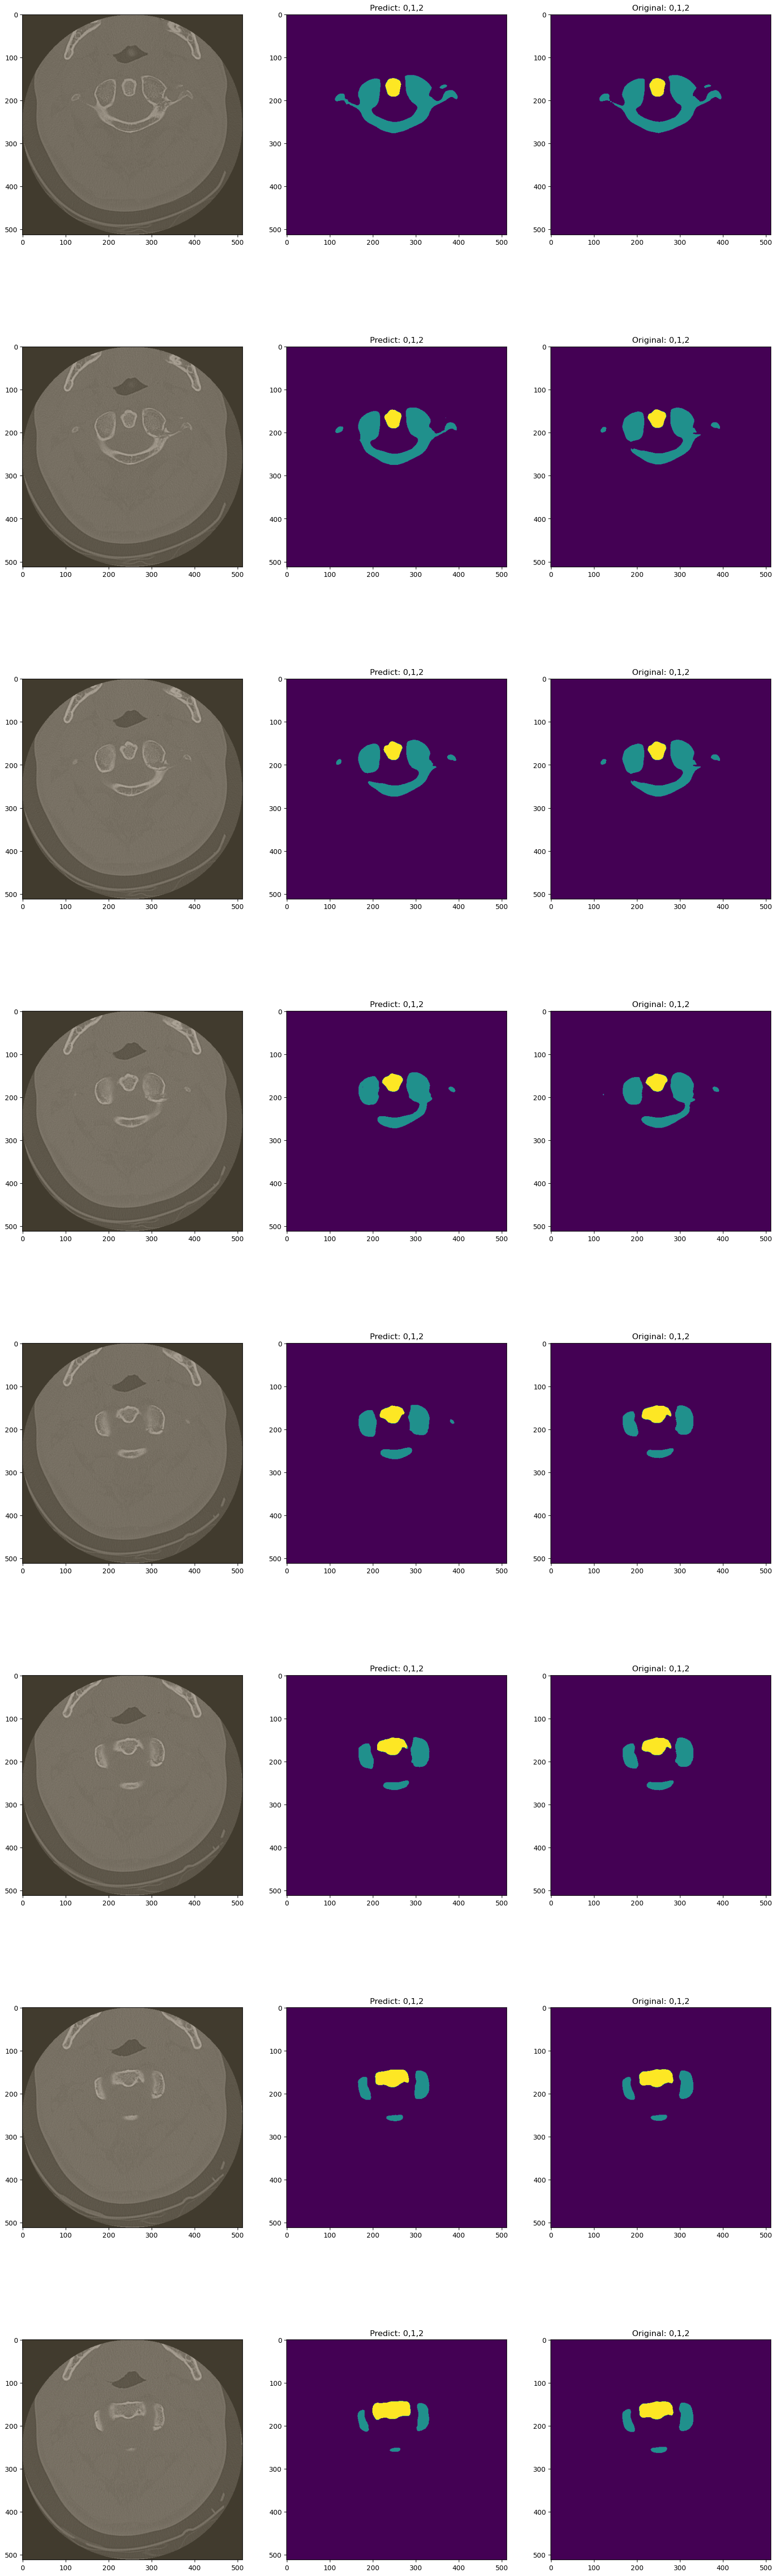

In [31]:
plt.rcParams['figure.figsize'] = (20, 70)
fig, axs = plt.subplots(batch[0].shape[0], 3)
for ind in range(batch[0].shape[0]):
    img, mask = batch[0][ind], batch[1][ind]
    img = img.unsqueeze(dim=0)
    pred = model(img)
    
    img = img.squeeze(dim=0)
    img_denormalized = denorm_transform(img)
    img_denormalized = img_denormalized.numpy().transpose((1, 2, 0))
    axs[ind, 0].imshow(img_denormalized)
    
    pred = np.argmax(pred.squeeze(dim=0).detach().cpu(), axis=0)
    pred = pred.numpy()
    axs[ind, 1].imshow(pred.astype(np.uint8))
    axs[ind, 1].set_title('Predict: ' + ','.join(list(np.unique(pred).astype('str'))))
    
    mask = mask.detach().cpu().numpy()
    mask = np.transpose(mask, (1, 2, 0))
    mask = np.argmax(mask, axis=-1)
    
    axs[ind, 2].imshow(mask.astype(np.uint8))
    axs[ind, 2].set_title('Original: ' + ','.join(list(np.unique(mask).astype('str'))))

In [32]:
test_dataset = BuildingDataset(test_df, dicom_path, masks, preprocessing=get_preprocessing(preprocessing_fn))

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers = 2)

In [33]:
test_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
test_epoch.run(test_loader)

valid: 100%|██████████| 171/171 [01:37<00:00,  1.76it/s, dice_loss - 0.003799, iou_score - 0.9925]


{'dice_loss': 0.0037989884789227046, 'iou_score': 0.9924932383654412}

In [35]:
wandb.finish()

epoch,▁▂▂▃▄▄▅▅▆▇▇█
lr,▂▅█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dice_loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_iou_score,▁▅▆█████████████████████████████████████
valid_dice_loss,██▇▆▇▅▄▄▅▁▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃
valid_iou_score,▁▁▂▃▂▄▅▅▄█▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▆▆▆▆
epoch,12
lr,5e-05
train_dice_loss,0.00262
train_iou_score,0.99486
valid_dice_loss,0.0038
